In [1]:
import pandas as pd
import ir_datasets as irds
from ir_measures import read_trec_qrels
from ir_measures import * 
from ir_measures import evaluator
import pyterrier as pt
from scipy.stats import ttest_ind
import os
from os import path as path
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Data Ingestion

In [2]:
DIR = '../..' # if this breaks replace with a full path to the repo

DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = f'{DIR}/judgments/main/qrels/'
annotation_directory = f'{DIR}/judgments/main/doccano/'

In [3]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [71]:
q_lookup = pd.DataFrame(dataset.queries_iter()).set_index("query_id").text.to_dict()

In [134]:
d_lookup = pd.DataFrame(dataset.docs_iter()).set_index("doc_id").text.to_dict()

In [4]:
all_qrels = []
for file in os.listdir(qrel_directory):
    print(file)
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

andrew-parry-qrels.txt
ferdinand-schlatt-qrels.txt
froebe-qrels.txt
guglielmo-faggioli-qrels.txt
harry-scells-qrels.txt
saber-zerhoudi-qrels.txt
sean-macavaney-qrels.txt
eugene-yang-qrels.txt


In [5]:
group_id_map ={
    'froebe' : 1,
    'ferdinand-schlatt' : 1,
    'andrew-parry' : 2,
    'eugene-yang' : 2,
    'guglielmo-faggioli' : 3,
    'harry-scells' : 3,
    'saber-zerhoudi' : 4,
    'sean-macavaney' : 4
}
all_qrels['group'] = all_qrels['annotator'].map(group_id_map)

In [6]:
all_comments = []
for file in os.listdir(annotation_directory):
    if file.endswith('.jsonl'):
        comments = pd.read_json(annotation_directory + file, lines=True)
        annotator = file.replace('.jsonl', '')
        comments['annotator'] = annotator
        # filter in case that comments 'Comments' column is an empty list
        comments = comments[comments['Comments'].apply(lambda x: len(x) > 0)]
        all_comments.append(comments)

all_comments = pd.concat(all_comments)[['text', 'annotator', 'label', 'Comments']]
all_comments['label'] = all_comments['label'].apply(lambda x: x[0])

In [53]:
all_comments

,text,annotator,label,Comments
0,"Gas. For hydrogen to become a liquid, you need...",froebe,Perfectly Relevant (3),[Description: What is the temperature in degre...
28,Definitions for Contour plowing. Here are all ...,froebe,Not Relevant (0),[A user is in a discussion about farming pract...
74,The sides AC and BD above are called the legs ...,froebe,Not Relevant (0),[Description:\nI have trapezoid in front of me...
130,Pseudobulbar palsy is characterized by the ina...,froebe,Not Relevant (0),[Description:\nI know that dysarthria can be c...
205,Left Ventricular Hypertrophy. Left Ventricular...,froebe,Not Relevant (0),[Description:\nWhat factors can contribute to ...
288,You might be interested to know that both the ...,froebe,Relevant (1),[Description:\nI am a nurse and already hold m...
389,Genera such as Rhynia have a similar life-cycl...,froebe,Not Relevant (0),[Description: tracheids are part of which tiss...
738,"After about 2 days (range 2-21 days), dependin...",froebe,Not Relevant (0),[Description:\nHow long is the complete life c...
1026,Deadly: A conceptual image of Legionella Pneum...,froebe,Not Relevant (0),[Description:\nI am in a discussion with a fri...
14,rösti (ˈrɜːstɪ) or rosti n (Cookery) a Swiss d...,guglielmo-faggioli,Relevant (1),"[This document, in my opinion, would be releva..."


In [86]:
all_comments[all_comments['annotator']=='saber-zerhoudi'][['text', 'Comments']].values

array([['Paris has two large international airports, Orly in the south and Roissy-Charles de Gaulle north of Paris. The closest to Paris is Orly airport, but Orly and Roissy serve different destinations so you would not have the choice. Cdg. 14 people found this useful.',
        list(['A passage is perfectly relevant (3) if it either contains direct information regarding the position of the airport in regards to the city Paris, or clear information about how far the CDG airport is from the centre of Paris (i.e., From CDG Airport, it takes about 45 minutes to get to the centre of Paris). Hightly relevant (2) if the passage contains a small detail or information indicating the position of the airport in regards to Paris (e.g., 16 miles southeast of Paris, 14 miles (23 kilometers) northeast of Paris) but surrounded of other unnecessary information regarding the size, occupancy, and nature of the airport CDG. Relevant passages have information about how much does it costs to get from the 

In [9]:
metrics = [AP(rel=2), NDCG(cutoff=10), R(rel=2)@100, P(rel=2, cutoff=10), RR(rel=2), RR(rel=2, cutoff=10)]

In [10]:
original_evaluator = evaluator(metrics, qrels=original_qrels)

In [11]:
def filter_qrels(qrel_df, filter_df):
    return pd.merge(qrel_df, filter_df[['query_id', 'doc_id']], 
                       on=['query_id', 'doc_id'], 
                       how='inner')

## Delta in Relevance Judgements

In [12]:
original_lookup = defaultdict(dict)

In [13]:
for row in original_qrels.itertuples():
    original_lookup[row.query_id][row.doc_id] = row.relevance

In [14]:
all_qrels['original_judgement'] = all_qrels.apply(lambda x : original_lookup[x.query_id][x.doc_id], axis=1)

In [140]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator,group,original_judgement
0,855410,8651770,2,0,andrew-parry,2,2
1,855410,8651771,2,0,andrew-parry,2,2
2,855410,8651772,1,0,andrew-parry,2,1
3,855410,8651775,3,0,andrew-parry,2,2
4,146187,1230566,1,0,andrew-parry,2,1
...,...,...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang,2,0
1111,168216,4713638,0,0,eugene-yang,2,0
1112,168216,1696466,0,0,eugene-yang,2,0
1113,168216,4245224,0,0,eugene-yang,2,0


In [157]:
conflicts = all_qrels.groupby(['query_id', 'doc_id']).filter(
    lambda x: (3 in x['relevance'].values) and (0 in x['original_judgement'].values)
)

# Sort the results for better readability
conflicts_sorted = conflicts.sort_values(['query_id', 'doc_id', 'annotator'])


In [166]:
value_counts = conflicts_sorted.groupby(['query_id', 'doc_id']).size().reset_index(name='count')
value_counts_sorted = value_counts.sort_values('count', ascending=False)

In [167]:
value_counts_sorted

,query_id,doc_id,count
0,1113437,7368423,2
1,1113437,8729219,2
2,1117099,5686676,2
3,1117099,8799096,2
4,131843,2943307,2
5,156493,1171591,2
6,490595,7698193,2
7,490595,7704029,2
8,573724,7498096,2


In [158]:
conflicts

,query_id,doc_id,relevance,iteration,annotator,group,original_judgement
1048,490595,7698193,2,0,andrew-parry,2,0
1052,490595,7704029,2,0,andrew-parry,2,0
1061,573724,7498096,2,0,andrew-parry,2,0
1082,156493,1171591,0,0,andrew-parry,2,0
1042,131843,2943307,3,0,saber-zerhoudi,4,0
1046,1113437,7368423,3,0,saber-zerhoudi,4,0
1048,1113437,8729219,3,0,saber-zerhoudi,4,0
1059,1117099,8799096,3,0,saber-zerhoudi,4,0
1062,1117099,5686676,3,0,saber-zerhoudi,4,0
1042,131843,2943307,0,0,sean-macavaney,4,0


In [165]:
q_lookup['156493']

'do goldfish grow'

In [164]:
d_lookup['1171591']

'Rating Newest Oldest. Best Answer: They can, but do not have to. Goldfish in a home aquarium are perfectly fine not hibernating. The vast majority of pond fish (goldfish, koi, comets, shubunkins and orfe) are related to the carp and have been overwintering in our climate very successfully for hundreds of years.Fish are cold blooded, which means that they take their body temperature from that of the surrounding environment.es they can and will if the conditions are right. Usually outside pond goldfish once the water reaches 50 degrees will begin their hibernation stage. If they are in a pond they should not be fed once the temps reach 55.'

In [142]:
result_sorted

,query_id,doc_id,saber_relevance,sean_relevance
10,1063750,7146776,3,0
12,1106007,7797167,3,0
13,1106007,8502783,3,0
14,1106007,8596078,3,0
16,1113437,7368423,3,0
2,1113437,7385221,3,0
3,1113437,7385222,3,0
18,1117099,5686676,3,0
8,1117099,8208315,3,0
9,1117099,8446504,3,0


In [139]:
saber = conflicts_sorted[conflicts_sorted['annotator']=='saber-zerhoudi']
saber

,query_id,doc_id,relevance,iteration,annotator,group,original_judgement
805,1063750,7146776,3,0,saber-zerhoudi,4,1
1009,1106007,7797167,3,0,saber-zerhoudi,4,2
1017,1106007,8502783,3,0,saber-zerhoudi,4,2
1019,1106007,8596078,3,0,saber-zerhoudi,4,2
1046,1113437,7368423,3,0,saber-zerhoudi,4,0
214,1113437,7385221,3,0,saber-zerhoudi,4,2
215,1113437,7385222,3,0,saber-zerhoudi,4,1
1062,1117099,5686676,3,0,saber-zerhoudi,4,0
423,1117099,8208315,3,0,saber-zerhoudi,4,3
427,1117099,8446504,3,0,saber-zerhoudi,4,3


In [138]:
cdg

,query_id,doc_id,relevance,iteration,annotator,group,original_judgement


In [45]:
all_qrels.groupby('group')['query_id'].nunique().sort_values(ascending=False).reset_index(name='query_count')

,group,query_count
0,4,15
1,2,13
2,1,9
3,3,9


In [143]:
def plot_for_qid(qrels, qid, original=False, group=4):
    # Create a cross-tab (transition matrix) between original and updated relevance grades
    qrels = qrels[qrels.query_id==qid]
    qrels = qrels[qrels['group']==group]
    sns.set_context("talk", font_scale=0.9)
    sns.set_style("ticks")
    annotators = qrels['annotator'].unique().tolist()
    print(annotators)
    if original:
        annotator_1 = 'Original'
        annotator_2 = 'Annotators'
        transition_matrix = pd.crosstab(all_qrels['original_judgement'], all_qrels['relevance'])
    else:
        annotator_1 = annotators[0]
        annotator_2 = annotators[1]
        transition_matrix = pd.crosstab(qrels[qrels['annotator']==annotator_1]['relevance'],qrels[qrels['annotator']==annotator_2]['relevance']) 
    
    # Plotting the transition matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='d')
    plt.subplots_adjust(bottom=0.2) 
    plt.xlabel(f'{annotator_2} Annotation')
    plt.ylabel(f'{annotator_1} Annotation')
    plt.show()

In [118]:
q_lookup['405717']

'is cdg airport in main paris'

['ferdinand-schlatt', 'froebe']


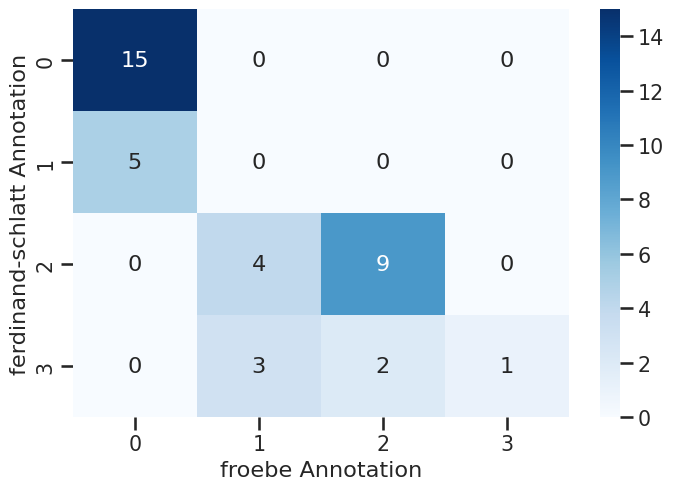

In [178]:
plot_for_qid(all_qrels, '1129237', group=1)

['saber-zerhoudi', 'sean-macavaney']


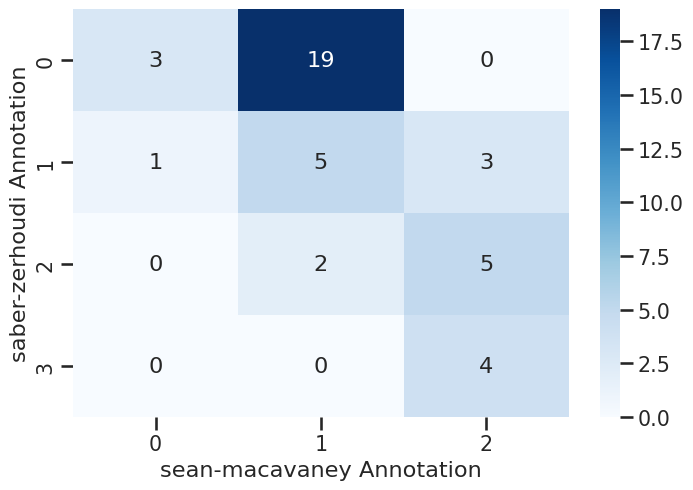

In [145]:
plot_for_qid(all_qrels, '405717', group=4)

['ferdinand-schlatt', 'froebe']


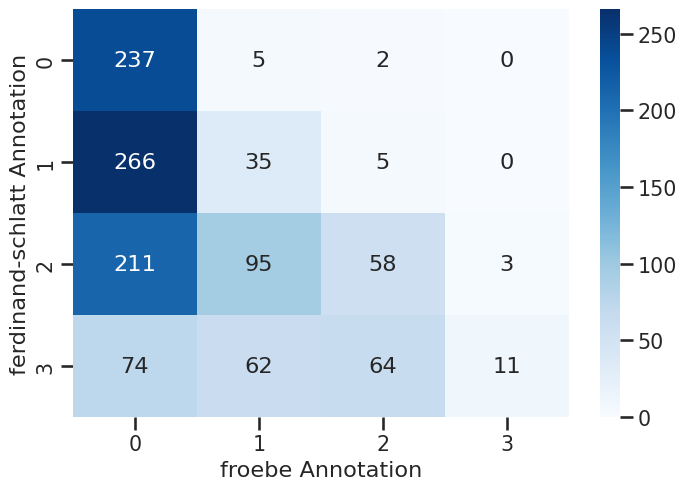

In [126]:

plot_for_qid(all_qrels, '1121402', group=1)

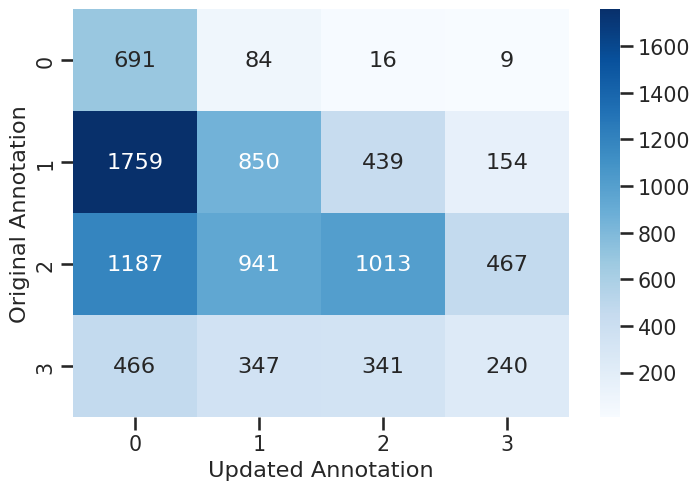

In [18]:
# Create a cross-tab (transition matrix) between original and updated relevance grades
sns.set_context("talk", font_scale=0.9)
sns.set_style("ticks")
transition_matrix = pd.crosstab(all_qrels['original_judgement'], all_qrels['relevance'])

# Plotting the transition matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='d')
plt.subplots_adjust(bottom=0.2) 
plt.xlabel('Updated Annotation')
plt.ylabel('Original Annotation')
plt.savefig('plots/grade_transition.svg', format='svg')
plt.show()

In [19]:
'''
# Get unique annotators
annotators = all_qrels['annotator'].unique()

# Determine the number of rows and columns for the grid
n_annotators = len(annotators)
n_cols = 4  # Set to 3 or any number you prefer
n_rows = math.ceil(n_annotators / n_cols)

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten axes in case we have multiple rows and columns
axes = axes.flatten()

# Plot each annotator's transition matrix in a separate subplot
for i, annotator in enumerate(annotators):
    # Filter the dataframe for the current annotator
    df_annotator = all_qrels[all_qrels['annotator'] == annotator]

    # Create the transition matrix for the current annotator
    transition_matrix = pd.crosstab(df_annotator['original_judgement'], df_annotator['relevance'])

    # Plot the transition matrix
    sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='d', ax=axes[i])

    # Set titles and labels
    axes[i].set_title(f'Annotator: {annotator}')
    axes[i].set_xlabel('Updated Annotation')
    axes[i].set_ylabel('Original Annotation')

# Hide any unused subplots (if annotators don't fill the grid)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()
'''

"\n# Get unique annotators\nannotators = all_qrels['annotator'].unique()\n\n# Determine the number of rows and columns for the grid\nn_annotators = len(annotators)\nn_cols = 4  # Set to 3 or any number you prefer\nn_rows = math.ceil(n_annotators / n_cols)\n\n# Create the subplots\nfig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))\n\n# Flatten axes in case we have multiple rows and columns\naxes = axes.flatten()\n\n# Plot each annotator's transition matrix in a separate subplot\nfor i, annotator in enumerate(annotators):\n    # Filter the dataframe for the current annotator\n    df_annotator = all_qrels[all_qrels['annotator'] == annotator]\n\n    # Create the transition matrix for the current annotator\n    transition_matrix = pd.crosstab(df_annotator['original_judgement'], df_annotator['relevance'])\n\n    # Plot the transition matrix\n    sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='d', ax=axes[i])\n\n    # Set titles and labels\n    axes[i].set_title

## Agreement

In [174]:
from statsmodels.stats.inter_rater import fleiss_kappa

kappa_scores = {}
FILTER = None
# Group by query_id and group_id
for (query_id, group_id), group in all_qrels.groupby(['query_id', 'group']): 
    # Filter to ensure all doc_ids have at least 2 rows (annotations)
    doc_counts = group['doc_id'].value_counts()
    eligible_docs = doc_counts[doc_counts >= 2].index
    if FILTER is not None: group = group[group['original_judgement'] == FILTER]
    filtered_group = group[group['doc_id'].isin(eligible_docs)]
    filtered_qrels = filter_qrels(original_qrels, filtered_group)
    filtered_group = pd.concat([filtered_group, filtered_qrels])
    
    # Create a contingency table for the relevance scores
    if not filtered_group.empty:
        crosstab = pd.crosstab(index=filtered_group['doc_id'], columns=filtered_group['relevance'])
        
        # Calculate Fleiss' Kappa
        if crosstab.sum().sum() > 0:  # Ensure there are ratings
            kappa_score = fleiss_kappa(crosstab)
            kappa_scores[(query_id, group_id)] = kappa_score

mean_kappa = {}
for (query_id, group_id), score in kappa_scores.items():
    if group_id not in mean_kappa:
        mean_kappa[group_id] = []
    mean_kappa[group_id].append(score)

# Compute the average Kappa scores for each group
for group_id, scores in mean_kappa.items():
    average_score = sum(scores) / len(scores) if scores else 0
    print(f"Mean Fleiss' Kappa for group {group_id}: {average_score}")


Mean Fleiss' Kappa for group 4: 0.28180269177316203
Mean Fleiss' Kappa for group 3: 0.16832687383930606
Mean Fleiss' Kappa for group 2: 0.2797043669794201
Mean Fleiss' Kappa for group 1: 0.22109435258757257


In [175]:
kappa_scores = {k : v for k,v, in kappa_scores.items() if k[1]==1}

In [176]:
kappa_scores

{('1121402', 1): 0.3532461677186655,
 ('1124210', 1): 0.21045830845593802,
 ('1129237', 1): 0.4276086712344154,
 ('148538', 1): 0.10158509605672261,
 ('168216', 1): 0.1521668932060708,
 ('264014', 1): 0.1883027849989579,
 ('359349', 1): 0.28010536061234326,
 ('527433', 1): 0.06311844205960973,
 ('87181', 1): 0.21325744894543008}

In [177]:
q_lookup['1129237']

'hydrogen is a liquid below what temperature'

In [22]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Sample structure of the all_qrels dataframe
# all_qrels = pd.DataFrame({
#     'query_id': [...],
#     'doc_id': [...],
#     'relevance': [...],
#     'original_judgement': [...],
#     'annotator': [...],
# })
binary_qrels = all_qrels.copy()
# Step 1: Create a unique identifier for each annotator pair and query
binary_qrels['annotator_pair'] = binary_qrels.apply(lambda row: tuple(sorted([row['annotator'], row['query_id']])), axis=1)
binary_qrels['relevance'] = binary_qrels['relevance'].map(lambda x : 1 if x >= 2 else 0)

# Step 2: Create an empty list to store Cohen's Kappa values
kappa_data = []

# Step 3: Loop through unique query IDs
for query_id in binary_qrels['query_id'].unique():
    # Filter the dataframe for the current query
    df_query = binary_qrels[binary_qrels['query_id'] == query_id]
    
    # Get the unique annotators for this query
    annotators = df_query['annotator'].unique()
    
    if len(annotators) == 2:  # Ensure we have exactly 2 annotators for Cohen's Kappa
        # Filter the data for each annotator
        df_annotator_1 = df_query[df_query['annotator'] == annotators[0]].sort_values(by=['doc_id'])
        df_annotator_2 = df_query[df_query['annotator'] == annotators[1]].sort_values(by=['doc_id'])
        
        # Ensure both annotators have annotated the same documents in the same order
        assert df_annotator_1['doc_id'].equals(df_annotator_2['doc_id']), "Doc IDs do not match between annotators."
        
        # Step 4: Calculate Cohen's Kappa for the relevance judgments
        kappa = cohen_kappa_score(df_annotator_1['relevance'], df_annotator_2['relevance'])
        
        # Step 5: Store the result in the list along with the annotator pair
        annotator_pair = tuple(sorted([annotators[0], annotators[1]]))  # Ensure consistent order
        kappa_data.append({
            'annotator_pair': annotator_pair,
            'query_id': query_id,
            'cohen_kappa': float(kappa)  # Ensure it's stored as a float
        })

# Step 6: Create a DataFrame from the Kappa results
kappa_df = pd.DataFrame(kappa_data)

# Step 7: Aggregate to get mean Cohen's Kappa for each annotator pair
mean_kappa_df = kappa_df.groupby('annotator_pair', as_index=False)['cohen_kappa'].mean()

# Display the mean Kappa DataFrame
print(mean_kappa_df)

                       annotator_pair  cohen_kappa
0         (andrew-parry, eugene-yang)     0.380724
1         (ferdinand-schlatt, froebe)     0.369349
2  (guglielmo-faggioli, harry-scells)     0.468242
3    (saber-zerhoudi, sean-macavaney)     0.337673


In [23]:
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np

def calculate_multilabel_agreement(all_qrels):
    agreement_scores = {}
    
    # Group by query_id and group_id
    for (query_id, group_id), group in all_qrels.groupby(['query_id', 'group']):
        
        # Get unique annotators and doc_ids
        annotators = group['annotator'].unique()
        doc_ids = group['doc_id'].unique()
        
        if len(annotators) == 2:  # Ensure we have exactly 2 annotators
            # Create a dictionary to store labels for each annotator
            labels = {annotator: {doc_id: set() for doc_id in doc_ids} for annotator in annotators}
            
            # Populate the labels dictionary
            for _, row in group.iterrows():
                labels[row['annotator']][row['doc_id']].add(row['relevance'])
            
            # Calculate Jaccard similarity for each document
            jaccard_scores = []
            for doc_id in doc_ids:
                set1 = labels[annotators[0]][doc_id]
                set2 = labels[annotators[1]][doc_id]
                if set1 or set2:  # Only calculate if at least one set is non-empty
                    jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                    jaccard_scores.append(jaccard)
            
            # Calculate average Jaccard similarity for this query and group
            if jaccard_scores:
                avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
                agreement_scores[(query_id, group_id)] = avg_jaccard

    # Compute mean agreement scores for each group
    mean_agreement = {}
    for (query_id, group_id), score in agreement_scores.items():
        if group_id not in mean_agreement:
            mean_agreement[group_id] = []
        mean_agreement[group_id].append(score)

    # Print average agreement scores for each group
    for group_id, scores in mean_agreement.items():
        average_score = sum(scores) / len(scores) if scores else 0
        print(f"Mean Jaccard similarity for group {group_id}: {average_score}")

    return mean_agreement

# Usage
# mean_agreement = calculate_multilabel_agreement(all_qrels)

In [24]:
mean_agreement = calculate_multilabel_agreement(all_qrels)

Mean Jaccard similarity for group 4: 0.3967146297920034
Mean Jaccard similarity for group 3: 0.5582711934981942
Mean Jaccard similarity for group 2: 0.4370714014665226
Mean Jaccard similarity for group 1: 0.3939144425072422
